<a href="https://colab.research.google.com/github/wzh1998/Random-Thoughts/blob/main/Multus_Microscope_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Download the image

In [25]:
!wget https://github.com/wzh1998/Random-Thoughts/raw/main/microscope.tif

--2021-09-17 22:37:03--  https://github.com/wzh1998/Random-Thoughts/raw/main/microscope.tif
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wzh1998/Random-Thoughts/main/microscope.tif [following]
--2021-09-17 22:37:03--  https://raw.githubusercontent.com/wzh1998/Random-Thoughts/main/microscope.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2209583 (2.1M) [image/tiff]
Saving to: ‘microscope.tif.4’

microscope.tif.4    100%[===================>]   2.11M  --.-KB/s    in 0.04s   

2021-09-17 22:37:03 (48.5 MB/s) - ‘microscope.tif.4’ saved [2209583/2209583]



### 1. Import libraries

In [26]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance

### 2. Transfer file format
PIL libraries cannot handle the given file's format (.tif), hence I decided to transfer the file to another lossless format **.tiff**. This process can be done using the OpenCV library.

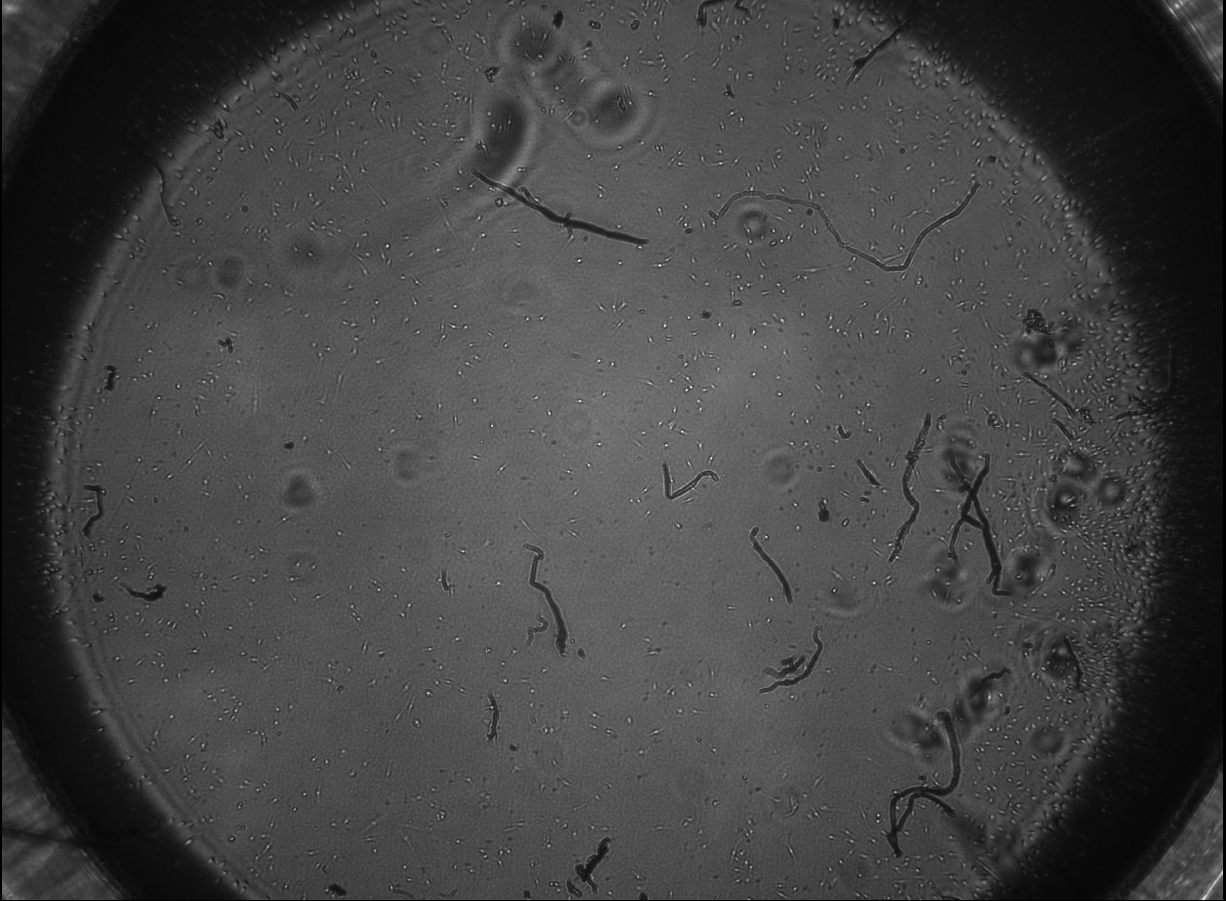

In [27]:
img_dir = "microscope.tif"
formatted_img_dir = "microscope.tiff"

# file format transformation
image = cv2.imread(img_dir)
cv2.imwrite(formatted_img_dir, image)

# check the microscope image
cv2_imshow(image)

### 3. Enhance the image
In the third step, I enhanced the image by adjusting the brightness and contrast to:
1. make the cells brighter and clearer.
2. make the contaminants and water droplet shadows darker and indistinguishable.

This process requires manually setting the enhancing factors, which is the major constraint of my method. However, as long as the experimental environment does not change (such as the illumination), the same setting can be applied to process multiple microscope images. 


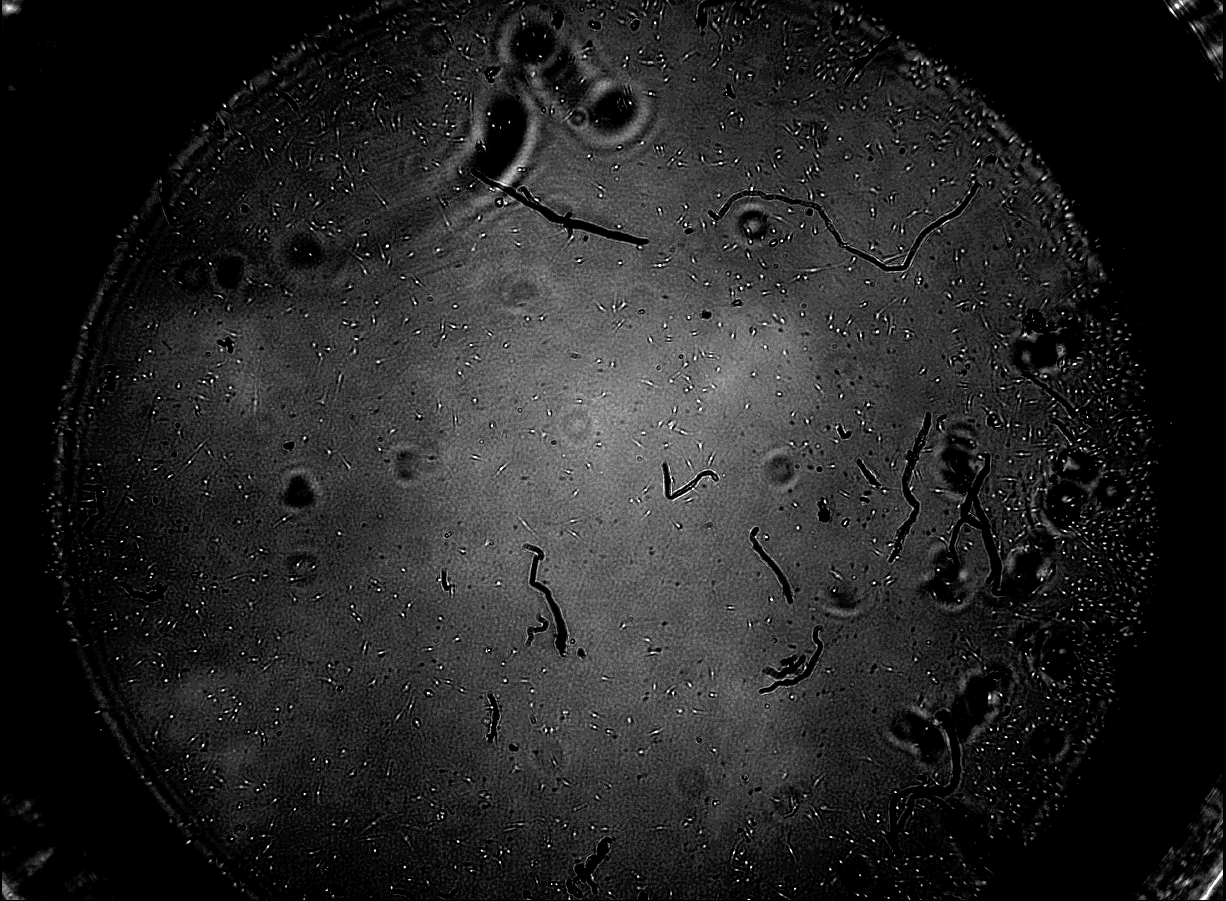

In [28]:
enhanced_img_dir = "microscope_enhanced.tiff"

image = Image.open(formatted_img_dir)

# reduce the brightness by specific degree to decrease the light in the central areas (since too much light could influence the thresholding process later).
brightness_factor = 0.15
enhancer = ImageEnhance.Brightness(image)
image_enhanced = enhancer.enhance(brightness_factor)

# increase the contrast to make cells more easy to to distinguished comapred with other regions.
contrast_factor = 20
enhancer = ImageEnhance.Contrast(image_enhanced)
image_enhanced = enhancer.enhance(contrast_factor)
image_enhanced.save(enhanced_img_dir)

# check the enhanced image
image_enhanced = cv2.imread(enhanced_img_dir)
cv2_imshow(image_enhanced)

### 4. Thresholding and border following
Next, I thresholded the image to further reduce the influence of the central area's light and other artefacts. Last but not least, the contour finding (a.k.a, border following) algorithm is applied to find the topological structure of the image, which allows us to count the cell numbers. The threshold parameter (170) was set manually to achieve the best effect. With different external conditions, you may need to change this parameter.

Specifically, I would like to mention that I set an exclusion rule to filter out large areas (>10 pixels) that cannot be cells, such that the artefacts will not be labelled.

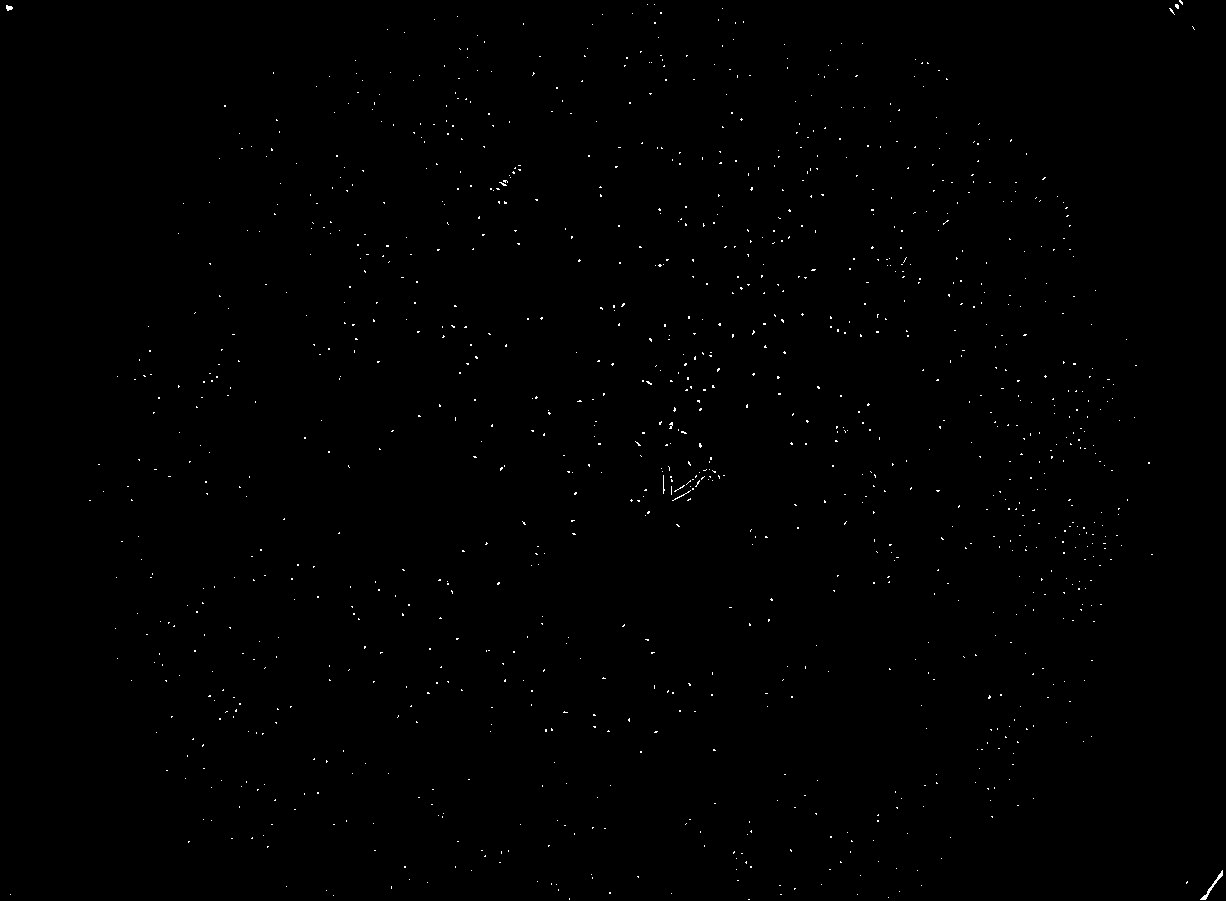

In [29]:
# convert the enhanced image to gray scale for threholding
gray = cv2.cvtColor(image_enhanced, cv2.COLOR_BGR2GRAY)

# note: here I manually set the threshold to 170 such that
# 1. pixel with value > 170 will be set as 255 (white)
# 2. pixel with value <= 170 will be set as 0 (black) 
# this value is picked manually over some experiments such that the thresholding effect achieves the best.
thresh = cv2.threshold(gray,170,255,cv2.THRESH_BINARY)[1]

# visualise the thresholded image
cv2_imshow(thresh)

Found  1158  cells from the image.


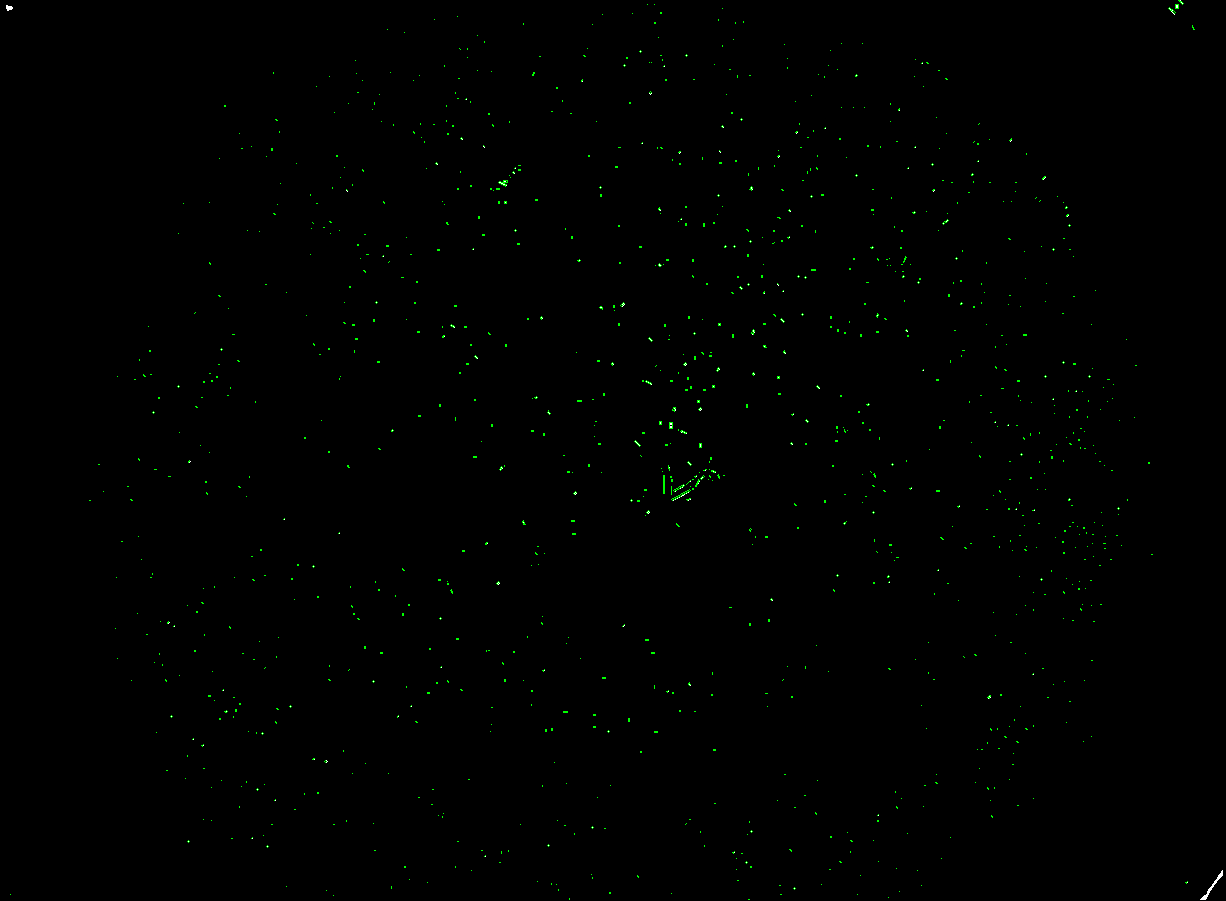

In [30]:
result = thresh.copy()
result = cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)

# find contours with the border following algorithm to count the number of cells
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
num_crops = 0

# iterate through labelled boxes
for cntr in contours:
  rect = cv2.minAreaRect(cntr)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  area = cv2.contourArea(cntr)
  # exclude areas that are too large to be a cell
  if(area < 10):
    # mark the cells that have been founded
    result = cv2.drawContours(result,[box],0,(0,255,0),1)
    num_crops += 1

# check the final result
print("Found ", num_crops, " cells from the image.")
cv2_imshow(result)

## Conclusion
In conclusion, I showed a process to explain how I address the given question and implemented a program to achieve the goal. As you can see that the artefacts become indistinguishable after processing, I think this solution also addresses the concerns in part 2 of the question.

The major advantage of my proposed method are:
1. Lightweight solution (easy & fast).
2. Performance looks OK (may need further quantitative evaluation, given the ground truth cell numbers).

The major disadvantages:
1. The parameters in enhancing and thresholding are picked manually and may need to be re-adjusted if the experimental condition changes. 

Last, a machine learning-based method can also be the solution, but it could take longer to implement.


